# Оценка сходства изображений с использованием сиамской сети с функцией тройных потерь
**Дата создания:** 2024/05/15<br>
**Исходник:** https://keras.io/examples/vision/siamese_network/<br>
**Описание:** Обучение сиамской сети на созданном наборе данных (100 якорных картинок) с использованием ResNet50, функция потерь - Triplet Loss, метод поиска сходства - вычисление косинусного сходства <br>
**Примечание:** Используется версия keras 3.1.0, картинки в формате JPEG

## Введение

[Сиамская сеть](https://en.wikipedia.org/wiki/Siamese_neural_network) - это тип сетевой архитектуры, который содержит две или более идентичных подсети, используемых для генерации векторов признаков для каждого входного сигнала и их сравнения.

Сиамские сети могут применяться для различных целей, таких как обнаружение дубликатов, поиск аномалий и распознавание лиц.

В этом примере используется сиамская сеть с тремя идентичными подсетями. Мы предоставим модели три изображения, на которых два из них будут похожи (выборки _anchor_ и _positive_), а третий будет не связан (_negative_). Наша цель состоит в том, чтобы модель научилась оценивать сходство между изображениями на основе косинусного расстояния.

Чтобы сеть могла обучаться, мы используем функцию потери триплетов. В этом примере мы определяем функцию потерь триплета следующим образом:

`L(A, P, N) = max(‖f(A) - f(P)‖2 - ‖f(A) - f(N)‖2 + margin, 0)`


## Импорт библиотек

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
pip install keras==3.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.0 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import keras
from pathlib import Path
from keras import applications
from keras import layers
from keras import losses
from keras import ops
from keras import optimizers
from keras import metrics
from keras import Model
from keras.applications import resnet
from tensorflow.keras import regularizers

#библиотеки для аугментации изображений
import glob
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import shutil

#размер изображения в наборе данных
target_shape = (150, 140)


## Аугментация изображений
Аугментация изображений - это методика создания дополнительных данных из имеющихся данных. В данном примере мы создадим набор якорных изображений и аументируем их для получения набора позитивных изображений

In [ ]:
path = '/content/drive/MyDrive/archive/'

###Преобразование png в jpg
В папке archive на гугл-диске находится 100 картинок, рассмотрим картинки в формате .png, конвертируем и сохраним их в формате .jpg. Для проверки выведем формат и цветовую модель

In [ ]:
png_images = glob.glob("/content/drive/MyDrive/archive/*.png")

###Аугментация JPG-картинок

В наборе данных archive.zip находится 100 якорных картинок, сделаем для каждой картинки одну аугментированную. Чтобы картинки отличались, рассмотрим несколько способов аугментации картинок - поворот, смещение по ширине, смещение по высоте, изменение яркости изображения, сдвиг, масштабирование, отзеркаливание по горизонтали и вертикали

In [ ]:
!unzip -u "/content/drive/MyDrive/archive.zip" -d "/archive/dop"

In [ ]:
path = pathlib.Path("/content/archive/")
for i, path in enumerate(path.glob('*.jpg')):
    new_name = str(i) + '.jpg'
    path.rename(new_name)

In [ ]:
augmented_images = []

In [ ]:
os.mkdir('/content/augmented_image/')

In [ ]:
output_dir = '/content/augmented_image/'

In [ ]:
img_path = '/content/archive/1.jpg'

In [ ]:
augmented_images = []

In [ ]:
def get_image_augm(img_path, datagen):
    img = image.load_img(img_path, target_size=(150,140)) #загрузка изображения и изменение его размера до 150x140 пикселей.
    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape) # изменение формы на (1,150,150,3)
    fig, axes = plt.subplots(1, 2, figsize=(10,5)) #отображение оригинального и аугментированного изображений
    for i, batch in enumerate(datagen.flow(x, batch_size=1)): #генерация аугментрированных изображений
        axes[i].imshow(image.array_to_img(batch[0]))
        axes[i].axis('off')
        augmented_images.append(batch[0])
        if i == 1: #Цикл прерывается после генерации двух изображений
            break
    return augmented_images


In [ ]:
def save_augmented_images(augmented_images, output_dir): #соранение аугментированного изображения
    for i, img in enumerate(augmented_images):
        img_path = f'{output_dir}/{i}.jpg'
        image.save_img(img_path, img)

In [ ]:
#поворот
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=155,
)

In [ ]:
#смещение по ширине
datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.5,
)

In [ ]:
#смещение по высоте
datagen = ImageDataGenerator(
    rescale=1./255,
    height_shift_range=.25,
)

In [ ]:
#изменение яркости
datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=(.1, .5),
    channel_shift_range=220
)

In [ ]:
#сдвиг
datagen = ImageDataGenerator(
    rescale=1./255,
   shear_range = 90,
)

In [ ]:
#масштабирование
datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.5
)

In [ ]:
#отзеркаливание изображения по горизонтали
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

In [ ]:
#отзеркаливание изображения по вертикали
datagen = ImageDataGenerator(
    rescale=1./255,
    vertical_flip=True
)

In [ ]:
get_image_augm(img_path, datagen)

In [ ]:
save_augmented_images(augmented_images, output_dir)

In [ ]:
shutil.move('/content/augmented_image','/content/drive/MyDrive/augmented_image') #перемещение изображения по указанному пути

## Загрузка набора данных

Будет загружен *полностью похожий* набор данных и распаковать его в каталог "~/.keras" в локальной среде.

Набор данных состоит из двух отдельных файлов:

* `left.zip содержит изображения, которые мы будем использовать в качестве якоря (*anchor*).
* `right.zip содержит изображения, которые мы будем использовать в качестве положительного образца, то есть изображения, похожие на якорь (*positive*).


In [ ]:
#создание путей, куда будут импортированы файлы
cache_dir = Path(Path.home()) / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

In [ ]:
#загрузка файлов по их идентификаторам из гугл-диска
!gdown --id 1VFpJWVScTEar5qqTjcw2sjd7TobbqXQJ
!gdown --id 12_DvbS5FrzWs6BBUObU68b3MVpRRpi91
#распаковка загруженных архивов
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1VFpJWVScTEar5qqTjcw2sjd7TobbqXQJ
To: /content/left.zip
100% 556k/556k [00:00<00:00, 124MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12_DvbS5FrzWs6BBUObU68b3MVpRRpi91
To: /content/right.zip
100% 538k/538k [00:00<00:00, 50.6MB/s]


## Подготовка данных

Используем `tf.data` для загрузки данных и генерации триплетов, которые нам
нужны для обучения сиамской сети. Используем сжатый список с именами файлов anchor, positive и negative в качестве источника. Изображения будут загружены и предварительно обработаны.

In [ ]:
#функция предобработки изображения
def preprocess_image(filename):
    image_string = tf.io.read_file(filename) #чтение изображения в виде строки
    image = tf.image.decode_jpeg(image_string, channels=3) #декодирование строки в изображение JPEG в формате RGB
    image = tf.image.convert_image_dtype(image, tf.float32) #преобразование типа данных изображения в float32
    image = tf.image.resize(image, target_shape) #изменение размера изображения до заданной формы
    return image

#функция предобработки якоря, позитивного и негативного изображения
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [ ]:
#импорт и сортировка изображений (для того, чтобы убедиться: якорь и позитивные изображения загружены в отсортированный порядок для сопоставления)
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images) #количество изображений

#создание датасета из списка путей к изображениям
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

rng = np.random.RandomState(seed=42) #получение случайного числа с фиксированным начальным значением seed=42

#перемешивание элементов в списках якорных и позитивных изображений
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

# объединение двух списков anchor_images и positive_images в один список negative_images
negative_images = anchor_images + positive_images

#перемешивание элементов в списке негативных изображений и получение случайной комбинации с фиксированным seed=32
np.random.RandomState(seed=32).shuffle(negative_images)

#создание набора данных из негативных изображений
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

#перемешивание элементов в наборе данных с буфером в 4096 элементов (гарантирует наиболее случайные элементы)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

#объединение трех наборов данных в один
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

#перемешивание объединенного набора данных (необходимо для лучшего обучения сети)
dataset = dataset.shuffle(buffer_size=1024)

#применение функции предобработки к каждому элементу набора данных
dataset = dataset.map(preprocess_triplets)

#разделение набора данных на обучающую(80%) и валидационную(20%) части
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

#разбитие данных на батчи по 32 элемент и предварительная загрузка данных для ускорения обучения
train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)


Рассмотрим несколько примеров триплетов. Обратите внимание, что первые два изображения выглядят похоже, в то время как третье всегда отличается.

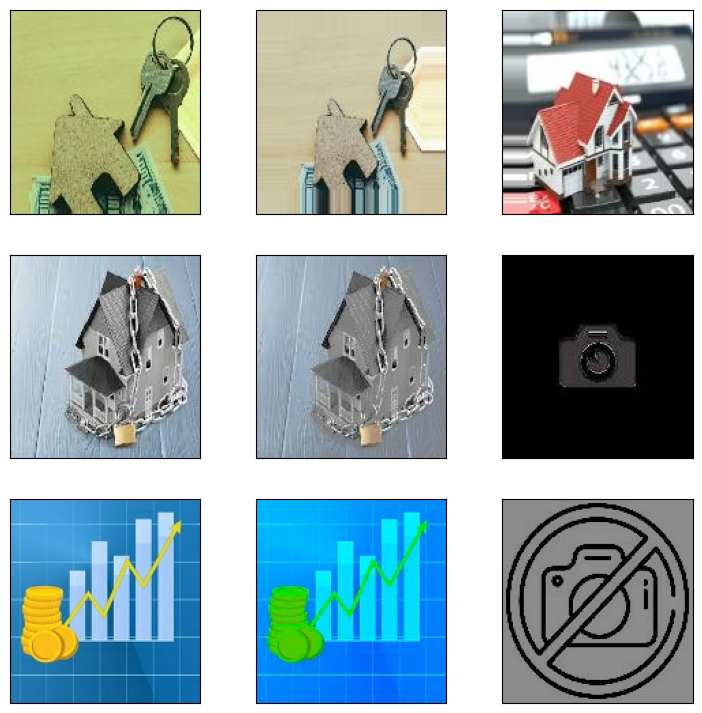

In [ ]:
def visualize(anchor, positive, negative):
    def show(ax, image):
        ax.imshow(image) #отображение изображения на заданной оси
        ax.get_xaxis().set_visible(False) #отключение осей
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) #создание фигуры размером 9x9

    axs = fig.subplots(3, 3) #создание сетки подграфиков размером 3x3
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

#преобразование одной партии данных из train_dataset в итератор numpy, а затем в список, и распаковка в три аргумента для функции визуализации
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

## Настройка модели генератора вложений

Сиамская сеть будет генерировать эмбеддинги для каждого из изображений триплета. Для этого используем модель ResNet50, предварительно обученную на ImageNet, и подключим к ней несколько Dense - слоев, чтобы научиться работать с эмбеддингами триплетов.

Зафиксируем веса всех слоев модели вплоть до слоя `conv 5_block 1_out`. Это необходимо для того, чтобы не повлиять на веса, которые модель уже изучила. Таким образом оставим несколько нижних слоев способными к обучению, чтобы точно настроить их вес.

In [ ]:
#загрузка предобученной модели ResNet50
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

#преобразование многомерного тензора в одномерный и добавление полносвязных слоев в 32 нейронами, 16 и 8,
#функцией активации ReLU и L2-регуляризации с коэффициентом 0.1 для предотвращения переобучения, а также
#применение нормализации батча для стабилизации и ускорения обучения

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.1))(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.1))(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(8, kernel_regularizer=regularizers.l2(0.1))(dense2)

#создание модели для извлечения признаков
embedding = Model(base_cnn.input, output, name="Embedding")

#заморозка всех слоев базовой модели ResNet50 до слоя с именем "conv5_block1_out", все слои после этого слоя остаются обучаемыми
trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Настройка модели сиамской сети

Сиамская сеть получит каждое из триплетных изображений в качестве входных данных, сгенерирует эмбеддинги и выведет расстояние между якорем и
положительным эмбеддингом, а также расстояние между якорем и отрицательным
эмбеддигом.


Чтобы вычислить расстояние, мы можем использовать пользовательский слой `DistanceLayer`, который возвращает оба значения в виде кортежа.

In [ ]:
#создание пользовательского слоя для вычисления расстояний между якорем и позитивом, а также между якорем и негативом
class DistanceLayer(layers.Layer):
    #вызов конструктора базового класса super().__init__(**kwargs), чтобы инициализировать слой с любыми переданными аргументами
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    #метод, реализующий логику вычислений: принимает на вход векторы эмбеддингов для якорных, положительных и отрицательных изображений
    #вычисляет евклидово расстояние между векторами и возвращает кортеж с расстояниями
    def call(self, anchor, positive, negative):
        ap_distance = ops.sum(tf.square(anchor - positive), -1)
        an_distance = ops.sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

#определение трех входных слоев для модели, каждый имеет форму размера изображения с тремя цветовыми каналами
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

#вычисление расстояний с использованием пользовательского слоя
distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

#создание модели Keras, которая принимает три входных изображения (якорь, положительное и отрицательное) и выдает расстояния между ними
siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

## Создание модели сиамской сети

Реализуем модель с пользовательским циклом обучения, чтобы мы могли вычислить потерю триплета, используя три эмбеддинга, созданные сиамской сетью.

Создадим экземпляр `Mean` метрики для отслеживания потерь в процессе обучения, а также вычислим точность. Для этого будем сравнивать расстояние от anchor до positive и negative. Чем меньше расстояние, тем картинки считаются наиболее похожими, а, значит, для похожих картинок выполняется следующее неравенство: `an_distance >  ap_distance` (расстояние между anchor и negative больше чем между anchor и positive)

In [ ]:
#пользовательский класс с методами для обучения, тестирования, вычисления потерь и точности
class SiameseModel(Model):
    #вызов конструктора для сохранения сиамской сети и значения разницы расстояния (margin) в аттрибутах класса, инициализация метрики для отслеживания потерь и точности
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")
        self.accuracy_tracker = metrics.Mean(name="accuracy")

    #метод для пропуска входных данных через сеть и возвращения результата
    def call(self, inputs):
        return self.siamese_network(inputs)

    #метод для обучения модели на одном шаге
    def train_step(self, data):
        with tf.GradientTape() as tape: #создание контекста для автоматического вычисления градиентов, чтобы вычислить градиенты потерь по отношению к обучаемым параметрам модели
            loss = self._compute_loss(data) #вычисление потерь

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights) #вычисление градиентов потерь по отношению к обучаемым весам сиамской сети
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights)) #обновление весов модели на основе вычисленных градиентов списком пар (градиент, параметр)

        self.loss_tracker.update_state(loss) #обновление метрики потерь
        self.accuracy_tracker.update_state(self._compute_accuracy(data)) #обновление метрики точности
        return {"loss": self.loss_tracker.result(), "accuracy": self.accuracy_tracker.result()} #возвращение текущих значений потерь и точности

    #метод для тестирования модели на одном шаге
    def test_step(self, data):
        loss = self._compute_loss(data) #вычисление потерь методом _compute_loss
        self.loss_tracker.update_state(loss) #обновление метрики потерь
        self.accuracy_tracker.update_state(self._compute_accuracy(data)) #обновление метрики точности
        return {"loss": self.loss_tracker.result(), "accuracy": self.accuracy_tracker.result()} #возвращение текущих значений потерь и точности

    #метод для вычисления потерь
    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data) #получение расстояния между якорем и положительным, а также якорем и отрицательным эмбеддингом
        loss = ap_distance - an_distance #вычисление разницы между расстояниями
        loss = tf.maximum(loss + self.margin, 0.0) #применение функции максимума для реализации триплетной потери с учетом разницы расстояния
        return loss #возвращение значения потерь

    #метод для вычисления точности
    def _compute_accuracy(self, data):
        ap_distance, an_distance = self.siamese_network(data) #получение расстояния между якорем и положительным, а также якорем и отрицательным эмбеддингом
        return tf.reduce_mean(tf.cast(tf.greater(an_distance, ap_distance), dtype=tf.float32)) #вычисление среднего значения, где расстояние до отрицательного больше, чем до положительного (указывает на правильную классификацию)

    @property
    #метод для получения метрик, возвращает список метрик, которые будут отслеживаться во время обучения и тестирования
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

## Обучение
Обучение сети будет происходить на 30 эпохах с learning rate = 0.00001. В конце обучения выведем графики loss и accuracy, а также сохраним модель для дальнейшего использования

In [ ]:
siamese_model = SiameseModel(siamese_network) #создание экземпляра модели
siamese_model.compile(optimizer=optimizers.Adam(0.00001)) #компиляция модели с оптимизатором Adam, скорость обучения=0.00001
history = siamese_model.fit(train_dataset, epochs=30, validation_data=val_dataset) #обучение модели в течение 30 эпох

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 104s 17s/step - accuracy: 0.8594 - loss: 0.3199 - val_accuracy: 0.9000 - val_loss: 0.2171
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - accuracy: 0.8086 - loss: 0.3043 - val_accuracy: 0.9500 - val_loss: 0.1965
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.9062 - loss: 0.2375 - val_accuracy: 0.8500 - val_loss: 0.2135
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.9023 - loss: 0.2104 - val_accuracy: 0.9500 - val_loss: 0.1357
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.8958 - loss: 0.1824 - val_accuracy: 0.9000 - val_loss: 0.1096
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.9206 - loss: 0.1546 - val_accuracy: 0.9000 - val_loss: 0.1346
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.9219 - loss: 0.1185 - val_accuracy: 0.9500 - val_loss: 0.1407
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.9570 - loss: 0.0959 - val_accuracy: 1.0000 - val_loss

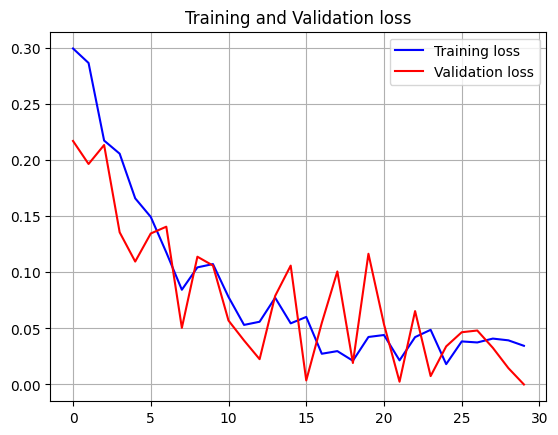

In [ ]:
#вывод графика потерь на обучающей и тестовой выборке
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.grid()
plt.show()

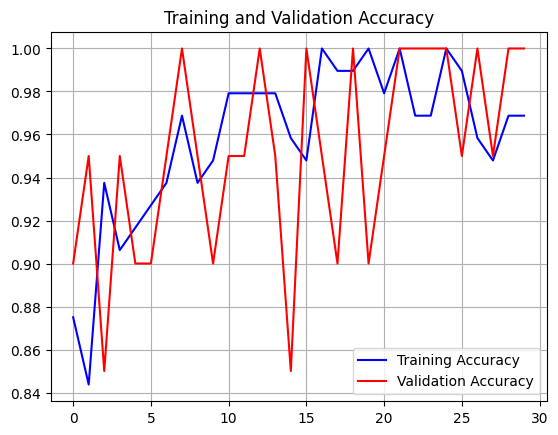

In [ ]:
#вывод графика точности на обучающей и тестовой выборке
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(accuracy, 'b', label='Training Accuracy')
plt.plot(val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#получение значений точности обучения и тестирований
train_accuracy = history.history['accuracy'][-1]
print(f'Training Accuracy: {train_accuracy * 100}%')

test_accuracy = history.history['val_accuracy'][-1]
print(f'Test Accuracy: {test_accuracy * 100}%')

Training Accuracy: 96.875%
Test Accuracy: 100.0%


## Тестирование сети
На этом этапе проверяем, как сеть научилась отличать эмбеддинги
в зависимости от того, принадлежат ли они похожим изображениям или нет.

Используем [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity) для измерения сходства между эмбеддингами.

Для этого выберем образец из набора данных, чтобы проверить сходство между
эмбеддингами, сгенерированными для каждого изображения. Визуализируем несколько триплетов и проверим сходство для первого триплета

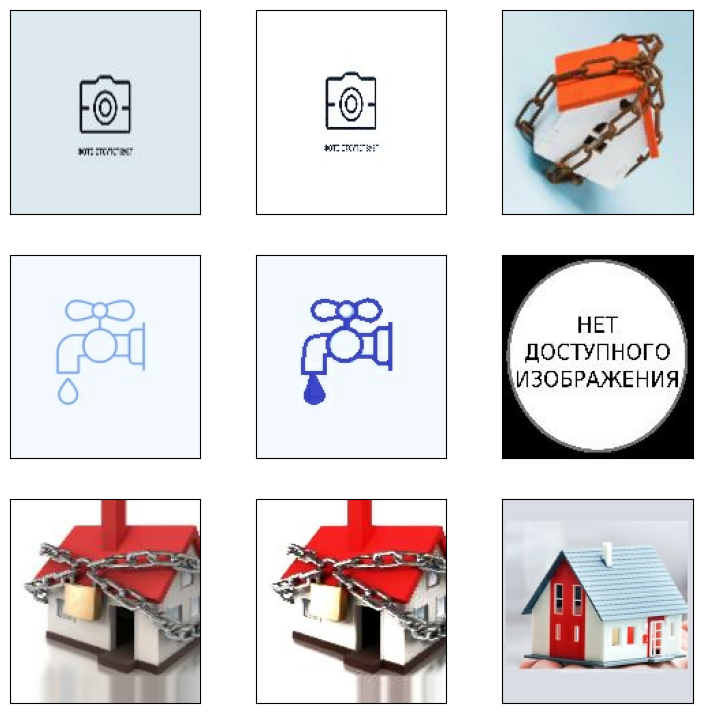

In [ ]:
#получение образца данных из train_dataset:
sample = next(iter(train_dataset))

#отображение изображений из триплетов
visualize(*sample)

#разделение образца на три части
anchor, positive, negative = sample

#получение эмбеддингов для каждого предварительно обработанного изображения
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

Вычисляем косинусное сходство между якорем и позитивными
изображениями и сравниваем его со сходством между якорем и негативными
изображениями.

Следует ожидать, что сходство между якорем и позитивными изображениями будет
больше, чем сходство между якорем и негативными изображениями.

In [ ]:
#создание объекта метрики косинусного сходства
cosine_similarity = metrics.CosineSimilarity()

#вычисление косинусного сходства между эмбеддингами изображений в триплете и их вывод
positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


Positive similarity: 0.9848989
Negative similarity 0.92037827


In [ ]:
#функция для проверки пользовательского изображения
def find_most_similar_image(my_image, train_dataset, anchor_images, embedding, resnet):
    # получение эмбеддинга для картинки
    my_image_embedding = embedding(resnet.preprocess_input(my_image))

    # вычисление косинусного сходства
    similarities_pos = []
    similarities_neg = []

    cosine_similarity = metrics.CosineSimilarity()

    for anchor, positive, negative in train_dataset:

        anchor_embedding = embedding(resnet.preprocess_input(anchor))
        positive_embedding = embedding(resnet.preprocess_input(positive))
        negative_embedding = embedding(resnet.preprocess_input(negative))

        positive_similarity = cosine_similarity(my_image_embedding, positive_embedding)
        similarities_pos.append(positive_similarity.numpy())

        negative_similarity = cosine_similarity(my_image_embedding, negative_embedding)
        similarities_neg.append(negative_similarity.numpy())

    #нахождение индекса картинки с наибольшим косинусным сходством positive и negative
    index_pos = np.argmax(similarities_pos)
    index_neg = np.argmax(similarities_neg)

    #вывод наибольшего сходства positive и negative и их разницы
    positive_similarity = similarities_pos[index_pos]
    negative_similarity = similarities_neg[index_neg]
    diff = positive_similarity - negative_similarity

    return positive_similarity, negative_similarity, diff

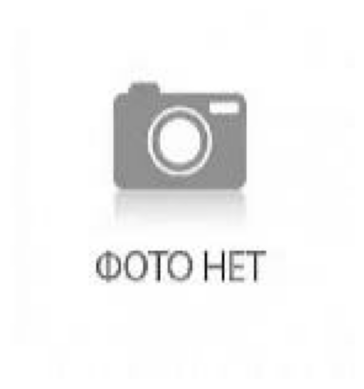

Positive similarity: 0.9471429
Negative similarity: 0.94698715
Difference: 0.00015574694


In [ ]:
my_image_path = "/content/drive/MyDrive/7.jpg"
my_image = preprocess_image(my_image_path)
plt.imshow(my_image)
plt.axis("off")
plt.show()
my_image = tf.expand_dims(my_image, axis=0)

result = find_most_similar_image(my_image, train_dataset, anchor_images, embedding, resnet)
print("Positive similarity:", result[0])
print("Negative similarity:", result[1])
print("Difference:", result[2])

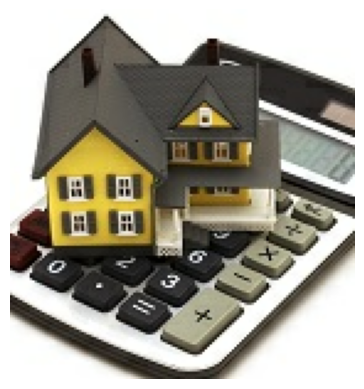

Positive similarity: 0.9351048
Negative similarity: 0.93406105
Difference: 0.0010437369


In [ ]:
my_image_path = "/content/drive/MyDrive/image_test.jpg"
my_image = preprocess_image(my_image_path)
plt.imshow(my_image)
plt.axis("off")
plt.show()
my_image = tf.expand_dims(my_image, axis=0)
result = find_most_similar_image(my_image, train_dataset, anchor_images, embedding, resnet)
print("Positive similarity:", result[0])
print("Negative similarity:", result[1])
print("Difference:", result[2])

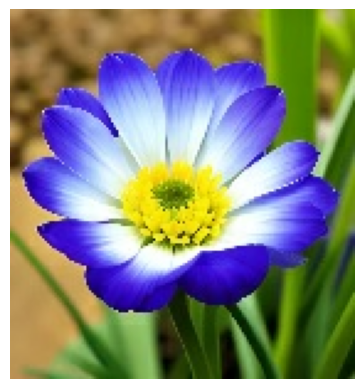

Positive similarity: 0.9402591
Negative similarity: 0.940992
Difference: -0.0007328987


In [ ]:
my_image_path = "/content/drive/MyDrive/img_10.jpg"
my_image = preprocess_image(my_image_path)
plt.imshow(my_image)
plt.axis("off")
plt.show()
my_image = tf.expand_dims(my_image, axis=0)
result = find_most_similar_image(my_image, train_dataset, anchor_images, embedding, resnet)
print("Positive similarity:", result[0])
print("Negative similarity:", result[1])
print("Difference:", result[2])

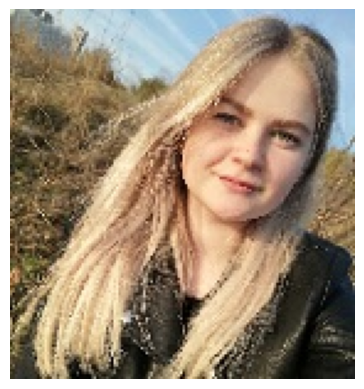

Positive similarity: 0.946012
Negative similarity: 0.9462358
Difference: -0.00022375584


In [ ]:
my_image_path = "/content/drive/MyDrive/img_6.jpg"
my_image = preprocess_image(my_image_path)
plt.imshow(my_image)
plt.axis("off")
plt.show()
my_image = tf.expand_dims(my_image, axis=0)
result = find_most_similar_image(my_image, train_dataset, anchor_images, embedding, resnet)
print("Positive similarity:", result[0])
print("Negative similarity:", result[1])
print("Difference:", result[2])

In [ ]:
!pip install --upgrade gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 12.3 M

In [ ]:
import gradio as gr

In [ ]:
def find_similar_image(input_image):

    #преобработка изображения
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = tf.image.resize(input_image, target_shape)
    input_image = tf.expand_dims(input_image, axis=0)

    #получение эмбеддингов
    input_image_embedding = embedding(resnet.preprocess_input(input_image))

    #создание списка для позитивного и негативного сходств
    similarities_pos = []
    similarities_neg = []

    #сравнение эмбеддингов с картинками в датасете
    for anchor, positive, negative in train_dataset:
        anchor_embedding = embedding(resnet.preprocess_input(anchor))
        #получение якорного, позитивного и негативного изображений
        positive_embedding = embedding(resnet.preprocess_input(positive))
        negative_embedding = embedding(resnet.preprocess_input(negative))

        #вычисление сходств
        positive_similarity = cosine_similarity(input_image_embedding, positive_embedding)
        similarities_pos.append(positive_similarity.numpy())

        negative_similarity = cosine_similarity(input_image_embedding, negative_embedding)
        similarities_neg.append(negative_similarity.numpy())

    #поиск наибольшего позитивного и негативного сходства
    index_pos = np.argmax(similarities_pos)
    index_neg = np.argmax(similarities_neg)

    #сравнение позитивного и негативного сходств
    most_similar_image = anchor_images[index_pos]
    positive_similarity = similarities_pos[index_pos]
    negative_similarity = similarities_neg[index_neg]
    diff = positive_similarity - negative_similarity
    if diff>0:
      msg = 'Изображение есть в базе данных'
    else:
      msg = 'Изображение в базе данных отсутствует'
    return positive_similarity, negative_similarity, diff, msg


iface = gr.Interface(fn=find_similar_image,
                     inputs="image",
                     outputs=[
                        gr.Textbox(label="Positive similarity"),
                        gr.Textbox(label="Negative similarity"),
                        gr.Textbox(label="Difference"),
                        gr.Textbox(label="Result")
                     ],
                     title="Поиск наиболее похожего изображения",
                     description="Загрузите изображение, чтобы найти наиболее похожее изображение из набора данных.")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c0ba2fa1ab3f9468d7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c0ba2fa1ab3f9468d7.gradio.live
